In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import matplotlib.pyplot as plt
from matplotlib import dates, ticker
import pandas as pd
pd.plotting.register_matplotlib_converters()
import os

import numpy as np
from ladybug.epw import EPW

import oshe as tc

Failed to load paths from C:\Users\tgerrish\Miniconda3\lib\site-packages\honeybee\config.json.
Path to radiance is set to: c:/radiance


In [2]:
idd_file = r"C:\openstudio-2.9.0\EnergyPlus\Energy+.idd"
epw_file = r"./example/weatherfile.epw"

idx = pd.date_range("2018-01-01", periods=8760, freq="60T", closed="left")

# Load epw
epw = EPW(epw_file)
dbt = np.array(epw.dry_bulb_temperature.values)
rh = np.array(epw.relative_humidity.values)
ws = np.array(epw.wind_speed.values)
hir = np.array(epw.horizontal_infrared_radiation_intensity.values)
global_rad = np.array(epw.global_horizontal_radiation.values)
direct_rad = np.array(epw.direct_normal_radiation.values)
diffuse_rad = np.array(epw.diffuse_horizontal_radiation.values)
sun_altitude = tc.helpers.sun_altitude(epw_file)

In [4]:
# Create DF and add climate variables

df = pd.DataFrame(index=idx)

df["DBT"] = dbt
df["RH"] = rh
df["WS"] = ws
df["HIR"] = hir
df["GLOBAL_RAD"] = global_rad
df["DIRECT_RAD"] = direct_rad
df["DIFFUSE_RAD"] = diffuse_rad

In [135]:
# Read NV openfield result
df["NV_MRT"] = pd.read_csv(r"C:\Users\tgerrish\OneDrive - BuroHappold\0045131 Ghadan Future Parks\openfield_nh.mrt", header=None).squeeze().values
df["NV_UTCI"] = pd.read_csv(r"C:\Users\tgerrish\OneDrive - BuroHappold\0045131 Ghadan Future Parks\openfield_nh.utci", header=None).squeeze().values

In [137]:
# Create UTCI and MRT values using SolarCal method

for shd in []
for mt in ["CONCRETE", "GRASS", "ASPHALT", "SAND", "SANDSTONE"]:
    
    print("\nRunning {}".format(mt))
    
    # Define ground material
    gnd_mat = tc.material.material_dict[mt]
    ground_zone = tc.geometry.Ground(gnd_mat, xy=5, depth=1.5, subsurface_size=5)

    # Calculate ground surface temperature
    of_srf_temp = tc.energyplus.run_energyplus(epw_file, idd_file, ground=ground_zone, shades=None, run=True)

    # Calculate incident solar direct and diffuse radiation
    of_dir_rad, of_dif_rad = tc.radiance.run_radiance(epw_file, ground=ground_zone, shades=None, run=True)

    # Calculate MRT
    of_mrt = tc.mrt.mean_radiant_temperature(surrounding_surfaces_temperature=of_srf_temp[0], horizontal_infrared_radiation_intensity=hir, diffuse_horizontal_solar=of_dif_rad.T[0], direct_normal_solar=of_dir_rad.T[0], sun_altitude=sun_altitude, ground_reflectivity=gnd_mat.reflectivity, sky_exposure=1, radiance=True)[0]

    # Calculate UTCI
    of_utci = tc.utci.universal_thermal_climate_index(dbt, of_mrt, ws, rh)
    
    df["TG_MRT_{}".format(mt)] = of_mrt
    df["TG_UTCI_{}".format(mt)] = of_utci



Running CONCRETE
Ground surface temperature simulation completed
EnergyPlus results loaded
Writing recipe contents to: C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual
Calculating solar values...
# Number of sun up hours: 4423
Writing sun matrix to C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual\sky\sunmtx.smx
Direct and diffuse solar radiation simulation completed
Radiance results loaded
Mean radiant temperature calculated [0.07 seconds]
Universal thermal climate index calculated [0.09 seconds]

Running GRASS
Ground surface temperature simulation completed
EnergyPlus results loaded
Writing recipe contents to: C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual
Calculating solar values...
# Number of sun up hours: 4423
Writing sun matrix to C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual\sky\sunmtx.smx
Direct and diffuse solar radiation simulation completed
Radiance results loaded
Mean radiant temperature calculated [0.07 seco

In [138]:
df.head()

,DBT,RH,WS,HIR,GLOBAL_RAD,DIRECT_RAD,DIFFUSE_RAD,NV_MRT,NV_UTCI,TG_MRT_CONCRETE,TG_UTCI_CONCRETE,TG_MRT_GRASS,TG_UTCI_GRASS,TG_MRT_ASPHALT,TG_UTCI_ASPHALT,TG_MRT_SAND,TG_UTCI_SAND,TG_MRT_SANDSTONE,TG_UTCI_SANDSTONE
2018-01-01 00:00:00,22.0,88,1.0,383,0,0,0,11.705620,11.147411,18.302833,22.621222,18.913669,22.803649,18.291202,22.617746,16.548006,22.095726,19.966261,23.117364
2018-01-01 01:00:00,18.0,59,3.1,349,0,0,0,11.705620,11.147411,14.548445,12.965912,15.172927,13.163919,14.495491,12.949118,12.718722,12.385341,16.256623,13.507317
2018-01-01 02:00:00,17.0,62,2.1,344,0,0,0,10.820136,7.939289,13.674571,13.902522,14.323804,14.116684,13.600343,13.878025,11.827788,13.292460,15.399841,14.471239
2018-01-01 03:00:00,17.0,59,3.1,343,0,0,0,10.105154,7.394860,13.235915,11.640754,13.912944,11.858909,13.143911,11.611105,11.378785,11.042120,14.971847,12.199981
2018-01-01 04:00:00,16.0,59,4.1,337,0,0,0,9.343943,7.498674,12.265314,8.401556,12.962855,8.624595,12.146516,8.363578,10.371573,7.796475,14.023969,8.964012


In [271]:
df.to_csv("C:/Users/tgerrish/Desktop/comparison.csv")

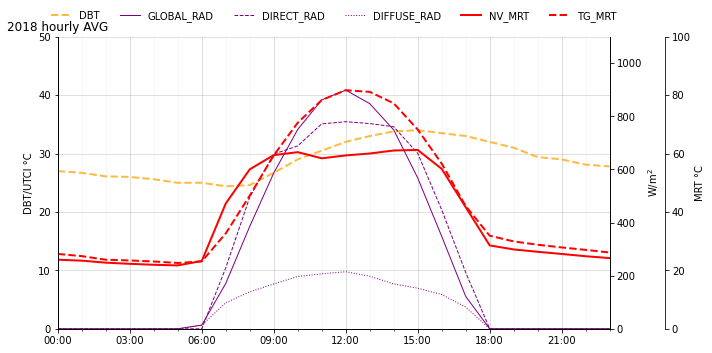

In [269]:
def plot_agg_day(time_period="2018", climate=True, mrt=True, utci=True):
    vals = df[time_period]
    vals = vals.groupby(vals.index.hour).median()
    vals.index = pd.date_range("2018-01-01 00:00:00", periods=24, freq="60T", closed="left")

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax_rad = ax.twinx()
    ax_mrt = ax.twinx()
    ax_mrt.spines['right'].set_position(('axes', 1.1))

    lns = []
    if climate:
        # Plot climate variables
        lns.append(ax.plot(vals.DBT, lw=2, ls="--", c="orange", alpha=0.75, label="DBT")[0])
        lns.append(ax_rad.plot(vals.GLOBAL_RAD, lw=1, ls="-", c="purple", alpha=1, label="GLOBAL_RAD")[0])
        lns.append(ax_rad.plot(vals.DIRECT_RAD, lw=1, ls="--", c="purple", alpha=1, label="DIRECT_RAD")[0])
        lns.append(ax_rad.plot(vals.DIFFUSE_RAD, lw=1, ls=":", c="purple", alpha=1, label="DIFFUSE_RAD")[0])

    if mrt:
        # Plot MRT variables
        lns.append(ax_mrt.plot(vals.NV_MRT, lw=2, ls="-", c="red", alpha=1, label="NV_MRT")[0])
        lns.append(ax_mrt.plot(vals.filter(regex="TG_MRT").median(axis=1).rename("TG_MRT"), lw=2, ls="--", alpha=1, c="red", label="TG_MRT")[0])

    if utci:
        # Plot UTCI variables
        lns.append(ax.plot(vals.NV_UTCI, lw=2, ls="-", c="blue", alpha=1, label="NV_UTCI")[0])
        lns.append(ax.plot(vals.filter(regex="TG_UTCI").median(axis=1).rename("TG_UTCI"), lw=2, ls="--", alpha=1, c="blue", label="TG_UTCI")[0])

    # Legend
    labs = [l.get_label() for l in lns]
    ncols = 2 if len(lns) == 2 else 4 if len(lns) == 4 else 6 if len(lns) == 6 else 4
    lgd = ax.legend(lns, labs, frameon=False, bbox_to_anchor=(0.5, 1.02), loc="lower center", ncol=ncols)
    [plt.setp(text, color="k") for text in lgd.get_texts()]

    # Format canvas
    ax.set_title(time_period + " hourly AVG", x=0)
    ax.set_xlim(vals.index.min(), vals.index.max())
    ax.set_ylim(0, 50)
    ax_rad.set_ylim(0, 1100)
    ax_mrt.set_ylim(0, 100)
    ax.xaxis.set_major_locator(dates.HourLocator(byhour=np.arange(0, 25, 3)))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    ax.xaxis.set_minor_locator(dates.HourLocator(byhour=np.arange(0, 25, 1)))
    [[i.spines[spine].set_visible(False) for spine in ['top']] for i in [ax, ax_rad, ax_mrt]]
    ax.grid(b=True, which='minor', axis='both', c="k", ls='--', lw=0.5, alpha=0.1)
    ax.grid(b=True, which='major', axis='both', c="k", ls='-', lw=0.5, alpha=0.25)
    plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')
    ax.set_ylabel("DBT/UTCI °C", color="k")
    ax_rad.set_ylabel("W/m$^2$", color="k")
    ax_mrt.set_ylabel("MRT °C", color="k")

    plt.tight_layout()
    return lns
    
a = plot_agg_day(time_period="2018", climate=True, mrt=True, utci=False)

Text(0, 0.5, 'TG_UTCI')

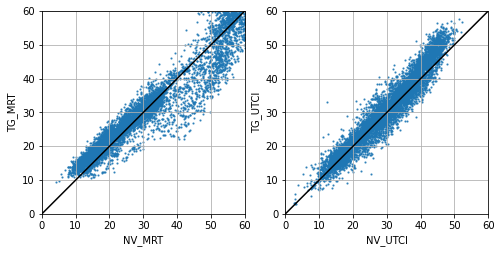

In [263]:

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 8))

var = "MRT"
ax1.scatter(df["NV_{}".format(var)], df.filter(regex="TG_{}".format(var)).median(axis=1), s=1.5, alpha=0.75)
ax1.plot(range(61), range(61), zorder=5, c="k")
ax1.set_aspect("equal")
ax1.set_xlim(0, 60)
ax1.set_ylim(0, 60)
ax1.grid()
ax1.set_xlabel("NV_"+var)
ax1.set_ylabel("TG_"+var)

var = "UTCI"
ax2.scatter(df["NV_{}".format(var)], df.filter(regex="TG_{}".format(var)).median(axis=1), s=1.5, alpha=0.75)
ax2.plot(range(61), range(61), zorder=5, c="k")
ax2.set_aspect("equal")
ax2.set_xlim(0, 60)
ax2.set_ylim(0, 60)
ax2.grid()
ax2.set_xlabel("NV_"+var)
ax2.set_ylabel("TG_"+var)

Text(0.5, 0, 'UTCI (C)')

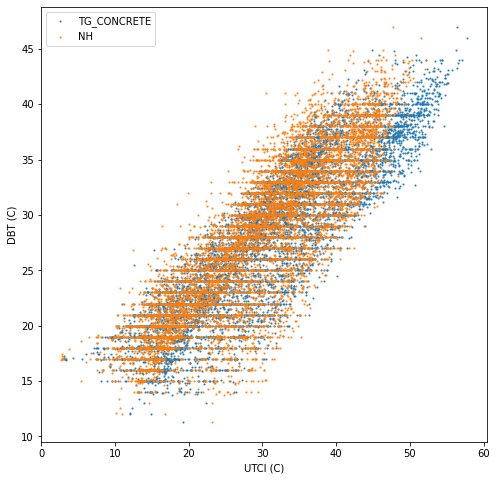

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(df.TG_CONCRETE, df.DBT, label="TG_CONCRETE", s=1.5, alpha=0.75)
ax.scatter(df.NH, df.DBT, label="NH", s=1.5, alpha=0.75)
ax.legend()
ax.set_ylabel("DBT (C)")
ax.set_xlabel("UTCI (C)")